### Imports

In [1]:
import os
import json
import random
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBRegressor
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

### Helper Function

In [2]:
def save_model(model, model_version, model_name='spec_photo_model'):
    os.makedirs(f'../models/{model_version}', exist_ok=True)
    model.save(f'../models/{model_version}/{model_name}.h5')

In [3]:
def save_history(history, model_version, history_name='history'):
    os.makedirs(f'../history/{model_version}', exist_ok=True)

    history_path = os.path.join(f'../history/{model_version}', f'{history_name}.json')
    with open(history_path, 'w') as f:
        json.dump(history.history, f)

In [4]:
def load_model(model_version, model_name='spec_photo_model'):
    model_path = f'../models/{model_version}/{model_name}.h5'
    if os.path.exists(model_path):
        return keras.models.load_model(model_path)
    else:
        raise FileNotFoundError(f"Model file {model_path} does not exist.")

In [5]:
def load_history(model_version, history_name='history'):
    """
    Load training history from a file.

    Parameters:
        model_version (str): Version of the model.
        history_name (str): Name of the history file (without extension).

    Returns:
        dict: Training history dictionary.
    """
    history_path = f'../history/{model_version}/{history_name}.json'
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
        return history
    else:
        raise FileNotFoundError(f"History file {history_path} does not exist.")

In [6]:
def plot_metrics(y_test, y_pred, threshold=0.2):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Dex accuracy metrics (since inputs are already in log space)
    mae_dex = mae  # identical unless you're converting from linear scale
    rmse_dex = rmse

    # Fraction of predictions within ±threshold dex
    within_tolerance = np.mean(np.abs(y_pred - y_test) <= threshold)

    print(f"📊 Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae_dex:.4f} dex")
    print(f"Root Mean Squared Error (RMSE): {rmse_dex:.4f} dex")
    print(f"R² Score: {r2:.4f}")
    print(f"Fraction within ±{threshold:.2f} dex: {within_tolerance:.2%}")

In [7]:
def plot_visualizations(y_test, y_pred, z_values=None, history=None):
    y_pred_flat = y_pred.ravel() if y_pred.ndim > 1 else y_pred

    if hasattr(y_test, 'iloc') and isinstance(y_test, pd.DataFrame):
        y_test_array = y_test.iloc[:, 0].values
    else:
        y_test_array = np.array(y_test)

    y_test_flat = y_test_array.ravel() if y_test_array.ndim > 1 else y_test_array
    residuals = y_test_flat - y_pred_flat

    # Residual Plot
    plt.figure(figsize=(8, 5))
    if z_values is not None:
        scatter = plt.scatter(
            y_pred_flat,
            residuals,
            c=z_values,
            cmap='viridis',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.3
        )
        plt.colorbar(scatter, label='Redshift (z)')
    else:
        sns.scatterplot(x=y_pred_flat, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot (Colored by Redshift)" if z_values is not None else "Residual Plot")
    plt.tight_layout()
    plt.show()

    # Parity Plot
    plt.figure(figsize=(8, 5))
    if z_values is not None:
        scatter = plt.scatter(
            y_test_flat,
            y_pred_flat,
            c=z_values,
            cmap='plasma',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.3
        )
        plt.colorbar(scatter, label='Redshift (z)')
    else:
        sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Parity Plot (Colored by Redshift)" if z_values is not None else "Parity Plot")
    plt.tight_layout()
    plt.show()

    # Residual Distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.title("Distribution of Prediction Errors")
    plt.tight_layout()
    plt.show()

    if history is not None:
        # Determine if history is a dictionary or a Keras History object
        _history = None
        if isinstance(history, dict):
            _history = history
        elif hasattr(history, 'history'):
            _history = history.history
        else:
            raise ValueError("Invalid history object provided. It should be a dictionary or a Keras History object.")
        
        # Training vs Validation Loss
        plt.figure(figsize=(8, 4))
        plt.plot(_history['loss'], label='Training Loss', color='steelblue')
        plt.plot(_history['val_loss'], label='Validation Loss', color='salmon')
        plt.xlabel("Epochs")
        plt.ylabel("Mean Squared Error")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Training vs Validation MAE
        plt.figure(figsize=(8, 4))
        plt.plot(_history['mae'], label='Training MAE', color='darkgreen')
        plt.plot(_history['val_mae'], label='Validation MAE', color='orange')
        plt.xlabel("Epochs")
        plt.ylabel("Mean Absolute Error")
        plt.title("Training vs Validation MAE")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Data Cleaning and Preprocessing

In [8]:
if not os.path.exists('models/'):
    os.makedirs('models/')

In [9]:
data = {
    "spectro_cols": [
        "h_alpha_flux", "oiii_5007_flux", "nii_6584_flux", "sii_6717_flux",
        "lick_mgb", "lick_fe5335", "d4000", "velocityDisp"
    ],
    "photometry_cols": [
        "modelMag_u", "modelMag_r", "modelMag_z", "fracDev_r", "petroRad_r",
        "extinction_u", "extinction_r", "extinction_z"
    ],
    "generic_cols": ["z", "zErr"],
    "target_col": ["logM_star"]
}
    
spectro_cols = data['spectro_cols']
photo_cols = data['photometry_cols']
generic_cols = data['generic_cols']
target_col = data['target_col']

In [10]:
if os.path.exists('data/processed/'):
    print("Data has already been processed and is ready for use.")
else:
    os.makedirs('data/processed/')
    df = pd.read_csv('data/raw/combined.csv')

    df_cleaned = df[~(df == -9999).any(axis=1)]
    df_cleaned = df_cleaned.drop_duplicates()
    df_cleaned = df_cleaned[df_cleaned['clean'] == 1]
    df_cleaned = df_cleaned[df_cleaned['type'] == 3] # type = 3 is for galaxies
    df_cleaned.drop(columns=['subClass', 'class', 'clean'], inplace=True)
    
    df = df_cleaned.copy()
    
    # --- Step 1: Log-transform emission line fluxes after clipping ---
    for col in ["h_alpha_flux", "oiii_5007_flux", "nii_6584_flux", "sii_6717_flux"]:
        df[col] = df[col].clip(lower=0)
        df[f"log_{col}"] = np.log1p(df[col])
        
    # --- Step 2: Physical filtering ---
    df = df[df["z"].between(0.00, 0.30)]
    df = df[df["zErr"] < 0.01]
    df = df[df["petroRad_r"] > 0.5]
    df = df[df["fracDev_r"].between(0, 1)]
    df = df[df["extinction_u"] < 1.5]
    
    # --- Step 3: Statistical IQR filtering ---
    def iqr_filter(data, col):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        return data[col].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

    for col in ["logM_star", "velocityDisp", "d4000"]:
        df = df[iqr_filter(df, col)]
        
    # --- Step 4: Multivariate outlier detection ---
    feature_cols = [f"log_{col}" for col in ["h_alpha_flux", "oiii_5007_flux", "nii_6584_flux", "sii_6717_flux"]] \
                   + ["lick_mgb", "lick_fe5335", "d4000", "velocityDisp"] \
                   + photo_cols + generic_cols

    df = df.dropna(subset=feature_cols)
    df_features = df[feature_cols]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df_features)

    iso = IsolationForest(contamination=0.2, random_state=42)
    outlier_flags = iso.fit_predict(features_scaled)

    df_clean = df[outlier_flags == 1].copy()
    
    # Splitting data into 3 parts: Spectrometry + Photometry, Photometry Only, and Unseen Data
    portions = np.array_split(df_clean, 3)

    portions[0].to_csv('data/processed/spectrometry_photometry.csv', index=False)
    portions[1].to_csv('data/processed/photometry_only.csv', index=False)
    portions[2].to_csv('data/processed/unseen_data.csv', index=False)
    print("Data has been processed and saved to 'data/processed/' directory.")

Data has already been processed and is ready for use.


### Spectometry + Photometry Base Model

In [11]:
df = pd.read_csv(f"data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols].copy()
y = df[target_col].copy()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
input_shape = X_train_scaled.shape[1]
optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)
x = layers.BatchNormalization(name='BatchNorm_64')(x)
x = layers.Activation('relu', name='Activation_64')(x)

# Layer 2
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)
x = layers.BatchNormalization(name='BatchNorm_128')(x)
x = layers.Activation('relu', name='Activation_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)
x = layers.BatchNormalization(name='BatchNorm_256')(x)
x = layers.Activation('relu', name='Activation_256')(x)

# Layer 4
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)
x = layers.BatchNormalization(name='BatchNorm_128_2')(x)
x = layers.Activation('relu', name='Activation_128_2')(x)

# Layer 5
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64_2')(x)
x = layers.Dropout(0.2, name='Dropout_64_2')(x)
x = layers.BatchNormalization(name='BatchNorm_64_2')(x)
x = layers.Activation('relu', name='Activation_64_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Spectro_Photo_Base_Regression_Model')

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Spectro_Photo_Base_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 18)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                1216      
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 BatchNorm_64 (BatchNormaliz  (None, 64)               256       
 ation)                                                          
                                                                 
 Activation_64 (Activation)  (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                               

In [15]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2922/2922 [==============================] - 27s 9ms/step - loss: 7.0090 - mae: 1.3828 - mse: 6.4951 - mape: 12.9656 - val_loss: 0.7079 - val_mae: 0.4215 - val_mse: 0.2707 - val_mape: 3.8924
Epoch 2/200
2922/2922 [==============================] - 25s 9ms/step - loss: 0.6677 - mae: 0.4686 - mse: 0.3532 - mape: 4.4054 - val_loss: 0.3807 - val_mae: 0.3373 - val_mse: 0.1820 - val_mape: 3.1539
Epoch 3/200
2922/2922 [==============================] - 25s 8ms/step - loss: 0.3718 - mae: 0.3709 - mse: 0.2345 - mape: 3.4933 - val_loss: 0.2964 - val_mae: 0.3412 - val_mse: 0.1979 - val_mape: 3.2172
Epoch 4/200
2922/2922 [==============================] - 25s 9ms/step - loss: 0.2565 - mae: 0.3111 - mse: 0.1719 - mape: 2.9329 - val_loss: 0.2010 - val_mae: 0.3016 - val_mse: 0.1286 - val_mape: 2.8319
Epoch 5/200
2922/2922 [==============================] - 25s 9ms/step - loss: 0.1805 - mae: 0.2589 - mse: 0.1221 - mape: 2.4464 - val_loss: 0.1004 - val_mae: 0.1625 - val_mse: 0.0573 - val_ma

In [16]:
model.save('models/spectro_photo_base_regression_model.h5')

In [17]:
y_pred = model.predict(X_test_scaled)

1566/1566 [==============================] - 3s 2ms/step


In [18]:
plot_metrics(y_test, y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0748 dex
Root Mean Squared Error (RMSE): 0.1107 dex
R² Score: 0.9495
Fraction within ±0.20 dex: 95.26%


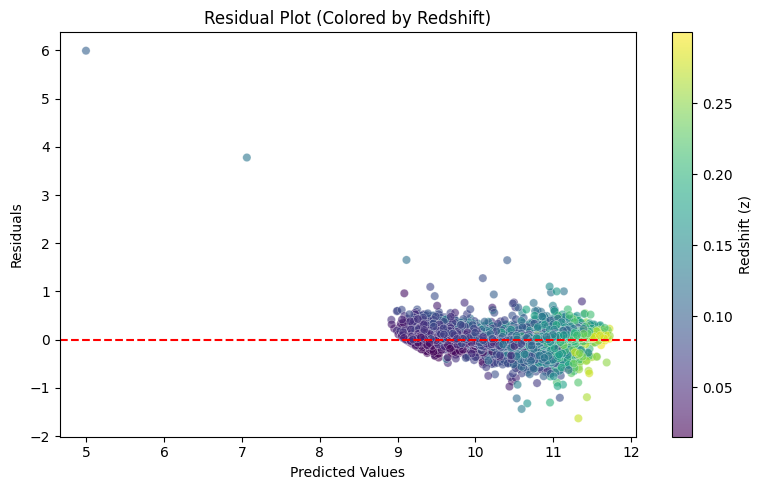

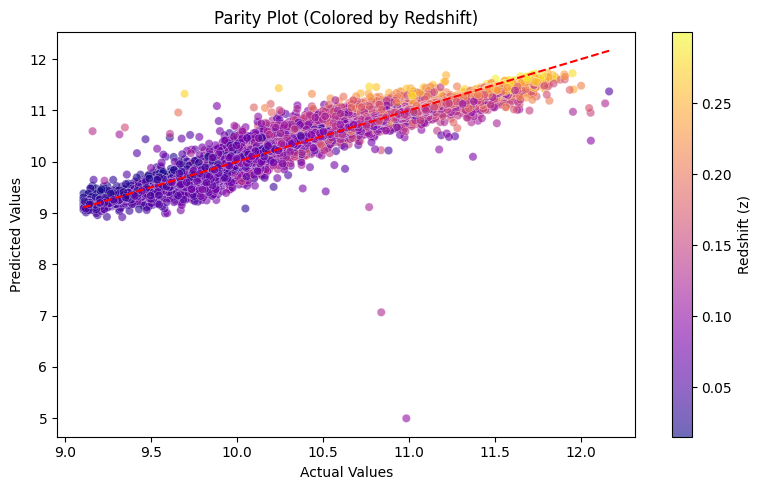

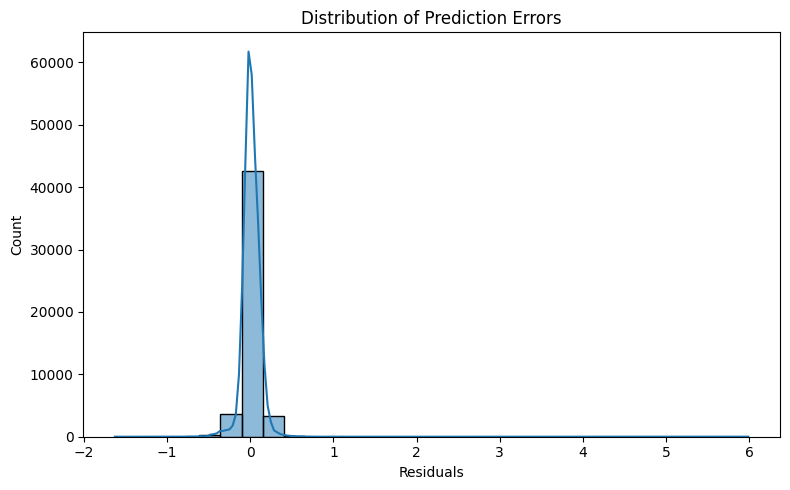

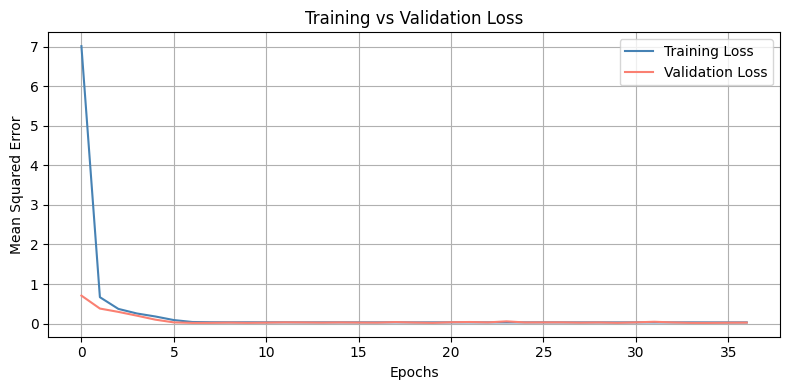

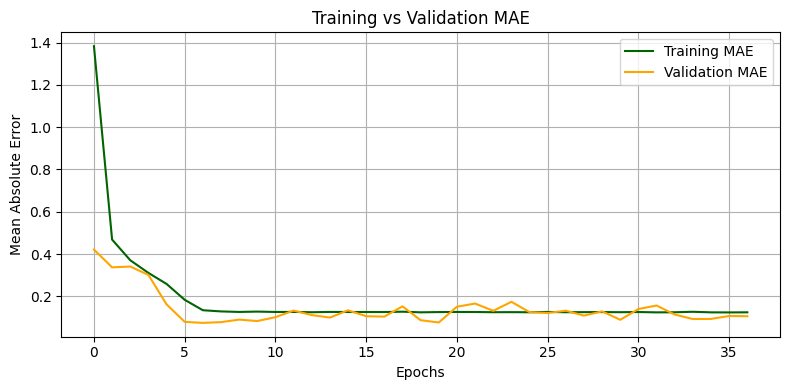

In [19]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)

### Photometry Transfer Learned Model

In [48]:
df = pd.read_csv(f"data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols].copy()
y = df[target_col].copy()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1 (frozen)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)
x = layers.BatchNormalization(name='BatchNorm_64')(x)
x = layers.Activation('relu', name='Activation_64')(x)

# Layer 2 (frozen)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)
x = layers.BatchNormalization(name='BatchNorm_128')(x)
x = layers.Activation('relu', name='Activation_128')(x)

# Layer 3 (trainable)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_new')(x)
x = layers.Dropout(0.2, name='Dropout_128_new')(x)
x = layers.BatchNormalization(name='BatchNorm_128_new')(x)
x = layers.Activation('relu', name='Activation_128_new')(x)

# Layer 4 (trainable)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64_new')(x)
x = layers.Dropout(0.2, name='Dropout_64_new')(x)
x = layers.BatchNormalization(name='BatchNorm_64_new')(x)
x = layers.Activation('relu', name='Activation_64_new')(x)

# Layer 5 (trainable)
x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), name='Dense_32_new')(x)
x = layers.Dropout(0.2, name='Dropout_32_new')(x)
x = layers.BatchNormalization(name='BatchNorm_32_new')(x)
x = layers.Activation('relu', name='Activation_32_new')(x)

# Output
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Photo_Transfer_Learned_Regression_Model')

# Load base model weights
model.load_weights('models/spectro_photo_base_regression_model.h5', by_name=True, skip_mismatch=True)

# Freeze reused layers
model.get_layer('Dense_64').trainable = False
model.get_layer('Dense_128').trainable = False

# Compile
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()


Model: "Photo_Transfer_Learned_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                704       
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 BatchNorm_64 (BatchNormaliz  (None, 64)               256       
 ation)                                                          
                                                                 
 Activation_64 (Activation)  (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                           

In [52]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2922/2922 [==============================] - 23s 8ms/step - loss: 5.1126 - mae: 1.3990 - mse: 4.8410 - mape: 13.1233 - val_loss: 1.4485 - val_mae: 1.0485 - val_mse: 1.1977 - val_mape: 9.7669
Epoch 2/200
2922/2922 [==============================] - 23s 8ms/step - loss: 0.6809 - mae: 0.5379 - mse: 0.4736 - mape: 5.0778 - val_loss: 0.4058 - val_mae: 0.4214 - val_mse: 0.2479 - val_mape: 3.9315
Epoch 3/200
2922/2922 [==============================] - 23s 8ms/step - loss: 0.3346 - mae: 0.3576 - mse: 0.2219 - mape: 3.3866 - val_loss: 0.1420 - val_mae: 0.2149 - val_mse: 0.0671 - val_mape: 2.0152
Epoch 4/200
2922/2922 [==============================] - 23s 8ms/step - loss: 0.1461 - mae: 0.2305 - mse: 0.0940 - mape: 2.1884 - val_loss: 0.0803 - val_mae: 0.1738 - val_mse: 0.0453 - val_mape: 1.6140
Epoch 5/200
2262/2922 [======================>.......] - ETA: 4s - loss: 0.0883 - mae: 0.1855 - mse: 0.0597 - mape: 1.7613

KeyboardInterrupt: 

In [ ]:
model.save('models/photo_transfer_learned_regression_model.h5')

In [ ]:
y_pred = model.predict(X_test_scaled)

1566/1566 [==============================] - 3s 2ms/step


In [ ]:
plot_metrics(y_test, y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.1322 dex
Root Mean Squared Error (RMSE): 0.1755 dex
R² Score: 0.8726
Fraction within ±0.20 dex: 79.01%


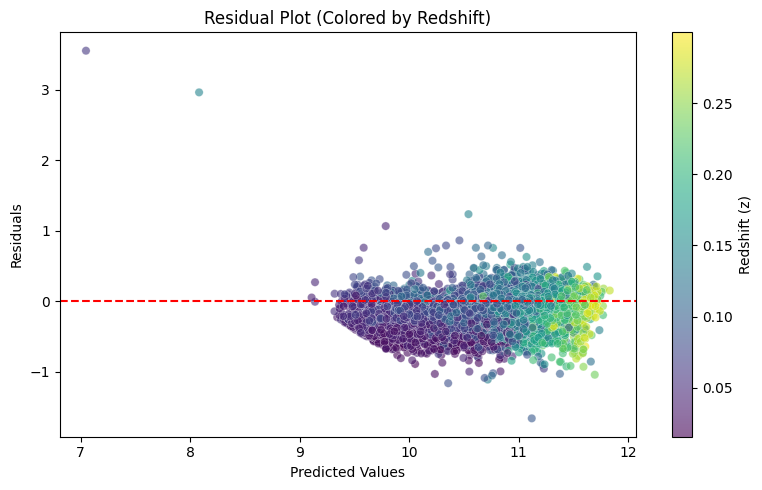

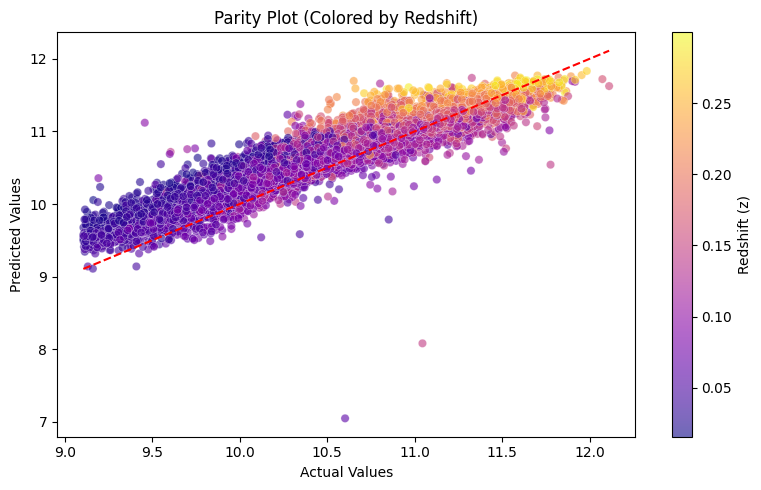

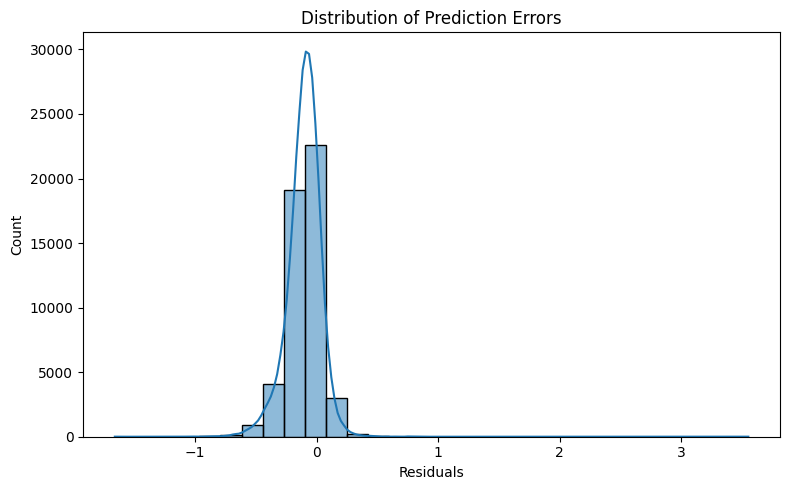

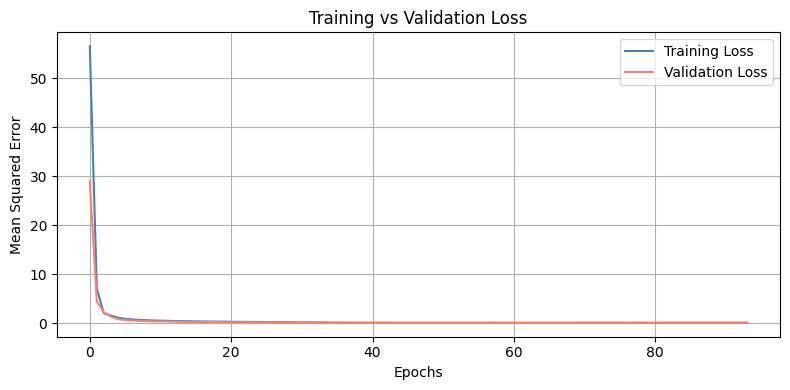

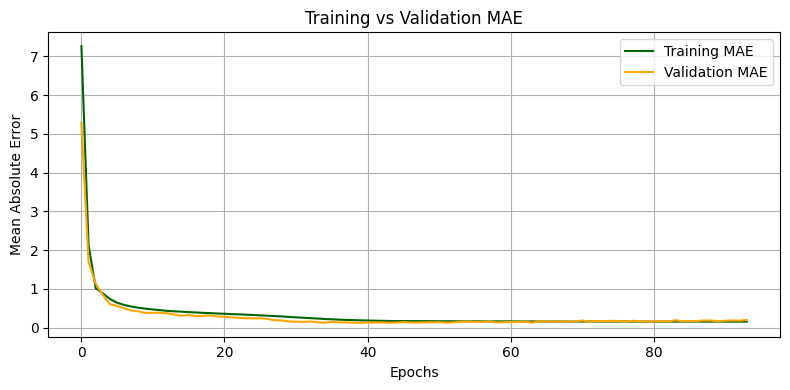

In [ ]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)

### Photo No Transfer Learning Model

In [29]:
df = pd.read_csv(f"data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols].copy()
y = df[target_col].copy()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1 (frozen)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)
x = layers.BatchNormalization(name='BatchNorm_64')(x)
x = layers.Activation('relu', name='Activation_64')(x)

# Layer 2 (frozen)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)
x = layers.BatchNormalization(name='BatchNorm_128')(x)
x = layers.Activation('relu', name='Activation_128')(x)

# Layer 3 (trainable)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)
x = layers.BatchNormalization(name='BatchNorm_128_2')(x)
x = layers.Activation('relu', name='Activation_128_2')(x)

# Layer 4 (trainable)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64_2')(x)
x = layers.Dropout(0.2, name='Dropout_64_2')(x)
x = layers.BatchNormalization(name='BatchNorm_64_2')(x)
x = layers.Activation('relu', name='Activation_64_2')(x)

# Layer 5 (trainable)
x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), name='Dense_32_2')(x)
x = layers.Dropout(0.2, name='Dropout_32_2')(x)
x = layers.BatchNormalization(name='BatchNorm_32_2')(x)
x = layers.Activation('relu', name='Activation_32_2')(x)

# Output
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Photo_No_Transfer_Learning_Regression_Model')

# Compile
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()


Model: "Photo_No_Transfer_Learning_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                704       
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 BatchNorm_64 (BatchNormaliz  (None, 64)               256       
 ation)                                                          
                                                                 
 Activation_64 (Activation)  (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                       

In [33]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2922/2922 [==============================] - 26s 9ms/step - loss: 8.2720 - mae: 1.7762 - mse: 7.9207 - mape: 16.6528 - val_loss: 1.7600 - val_mae: 1.1094 - val_mse: 1.4330 - val_mape: 10.3113
Epoch 2/200
2922/2922 [==============================] - 25s 9ms/step - loss: 0.9300 - mae: 0.6051 - mse: 0.6526 - mape: 5.6969 - val_loss: 0.6047 - val_mae: 0.5454 - val_mse: 0.3847 - val_mape: 5.0934
Epoch 3/200
2922/2922 [==============================] - 25s 8ms/step - loss: 0.5380 - mae: 0.4411 - mse: 0.3731 - mape: 4.1543 - val_loss: 0.2754 - val_mae: 0.3512 - val_mse: 0.1578 - val_mape: 3.2639
Epoch 4/200
2922/2922 [==============================] - 25s 9ms/step - loss: 0.2931 - mae: 0.3191 - mse: 0.2049 - mape: 3.0073 - val_loss: 0.0733 - val_mae: 0.0952 - val_mse: 0.0181 - val_mape: 0.8868
Epoch 5/200
2922/2922 [==============================] - 25s 8ms/step - loss: 0.0706 - mae: 0.1535 - mse: 0.0428 - mape: 1.4494 - val_loss: 0.0203 - val_mae: 0.0624 - val_mse: 0.0094 - val_m

In [34]:
model.save('models/photo_no_transfer_learning_regression_model.h5')

In [35]:
y_pred = model.predict(X_test_scaled)

1566/1566 [==============================] - 4s 2ms/step


In [36]:
plot_metrics(y_test, y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0694 dex
Root Mean Squared Error (RMSE): 0.1044 dex
R² Score: 0.9549
Fraction within ±0.20 dex: 95.47%


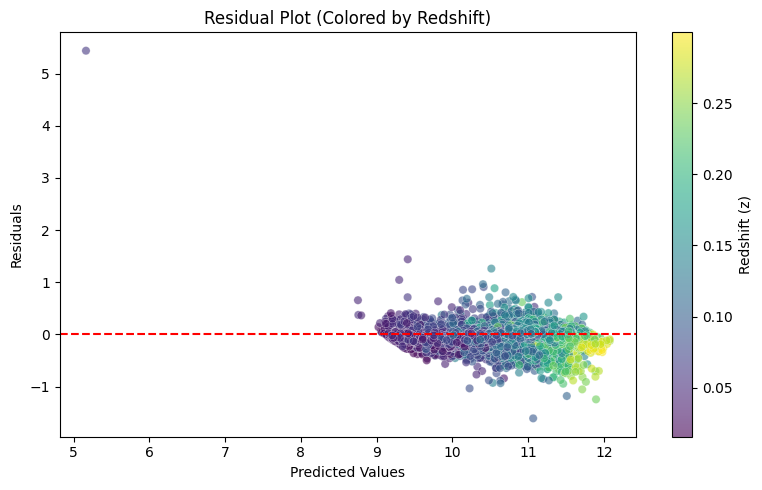

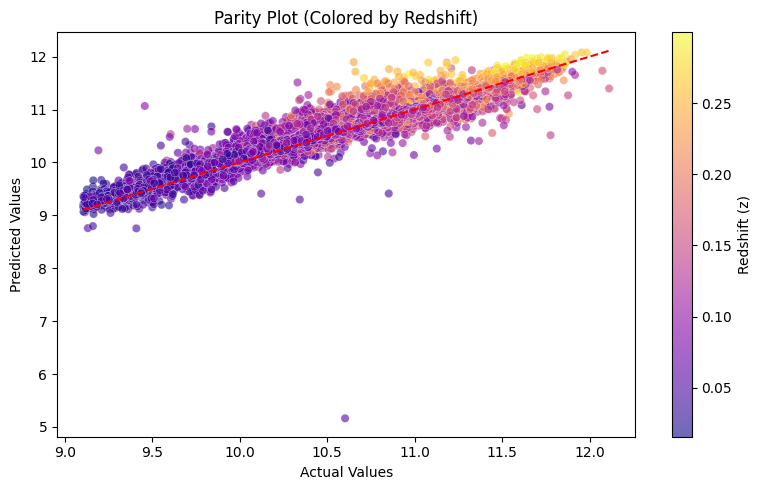

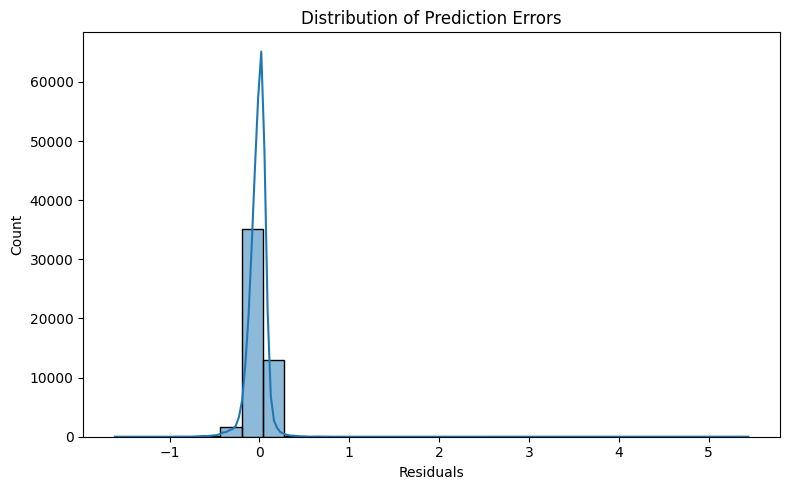

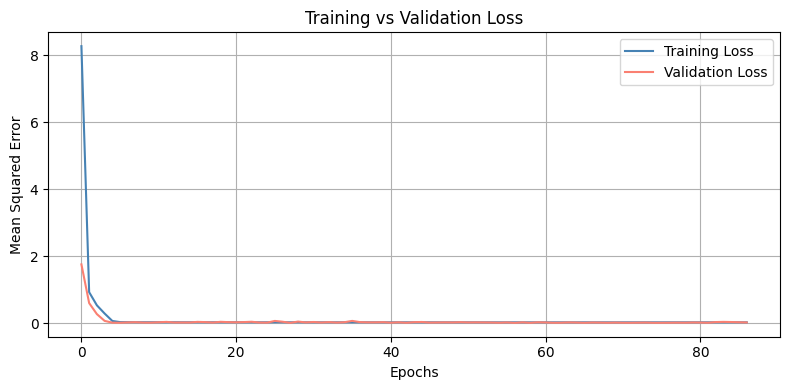

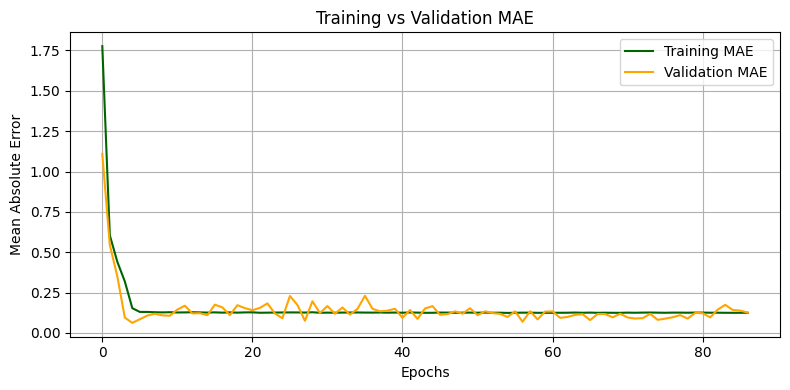

In [37]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)

### Feature Importance Analysis

In [38]:
df = pd.read_csv('data/processed/spectrometry_photometry.csv')

X = df[spectro_cols + photo_cols + generic_cols].copy()
y = df[target_col].copy()

In [39]:
# Train/Val Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Normalize inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

C:\Users\Sahil\AppData\Local\Temp\ipykernel_3640\688112782.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled, y_train)


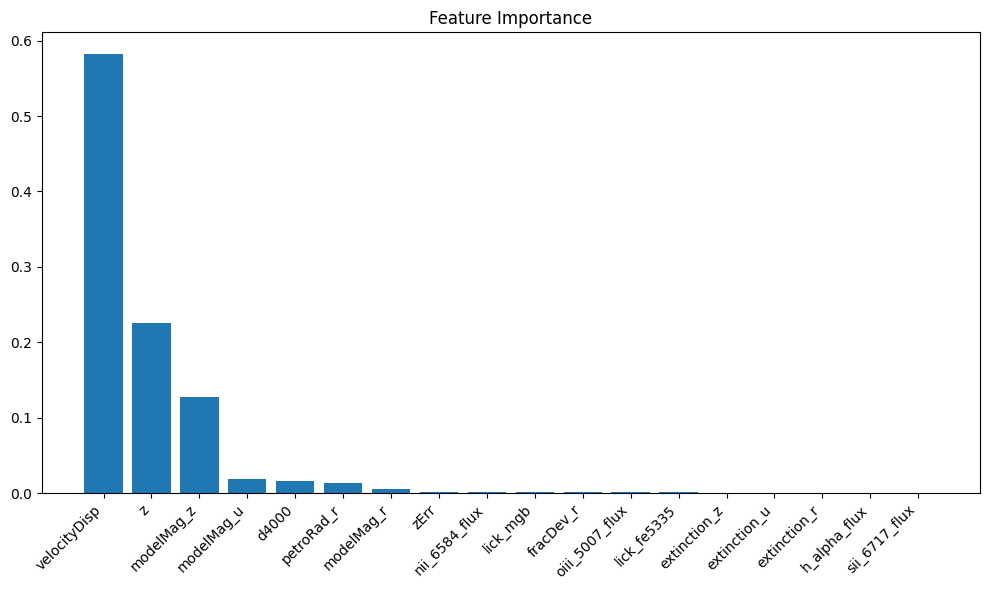

In [42]:
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx], align='center')
plt.xticks(range(len(importances)), np.array(spectro_cols+photo_cols+generic_cols)[sorted_idx], rotation=45, ha='right')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [43]:
plot_metrics(np.squeeze(y_test), y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0498 dex
Root Mean Squared Error (RMSE): 0.0839 dex
R² Score: 0.9707
Fraction within ±0.20 dex: 96.77%


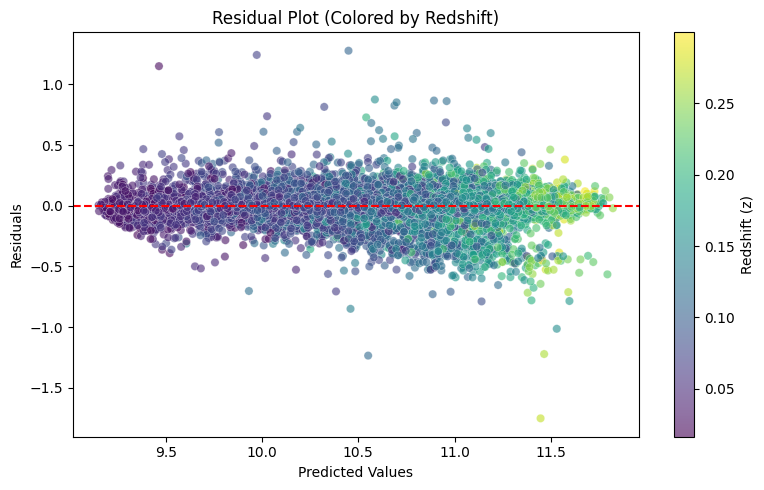

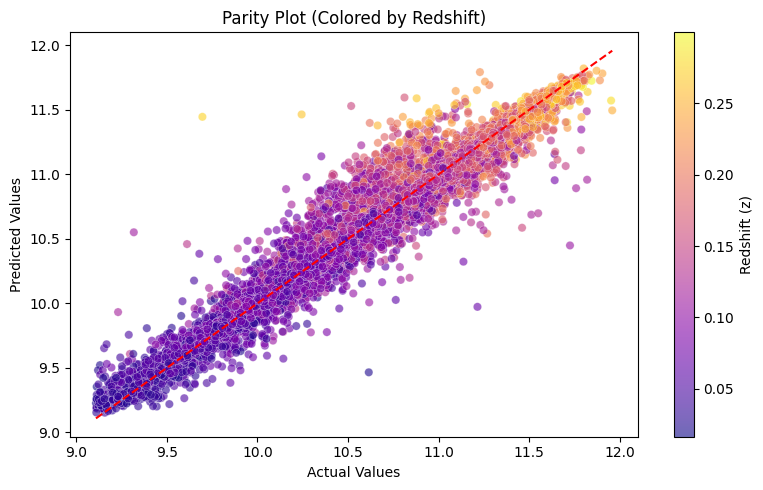

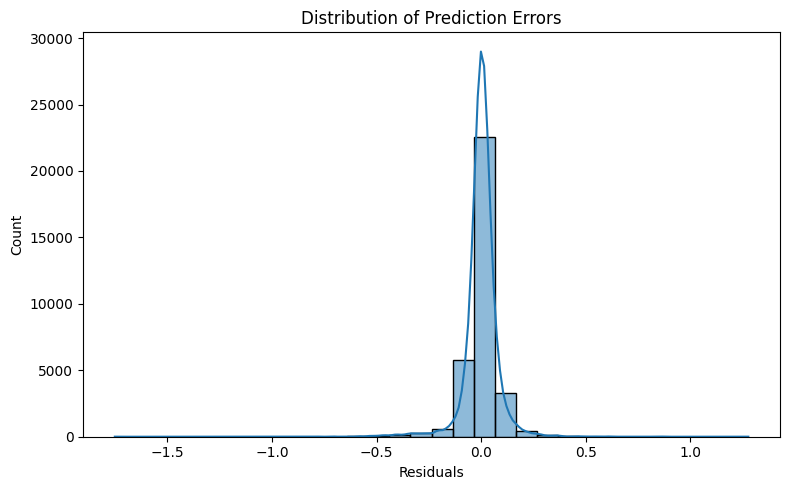

In [44]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'])

### Neural network with top features

In [54]:
top_features = ["velocityDisp", "z", "modelMag_z", "modelMag_u", "d4000", "petroRad_r", "modelMag_r", "zErr", "nii_6584_flux", "lick_mgb", "fracDev_r", "oiii_5007_flux"]

In [55]:
df = pd.read_csv('data/processed/spectrometry_photometry.csv')

In [56]:
X = df[top_features].copy()
y = df[target_col].copy()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(inputs)
x = layers.Dropout(0.2, name='Dropout_128')(x)
x = layers.BatchNormalization(name='BatchNorm_128')(x)
x = layers.Activation('relu', name='Activation_128')(x)

# Layer 2
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(x)
x = layers.Dropout(0.2, name='Dropout_64')(x)
x = layers.BatchNormalization(name='BatchNorm_64')(x)
x = layers.Activation('relu', name='Activation_64')(x)

# Layer 3
x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), name='Dense_32')(x)
x = layers.Dropout(0.2, name='Dropout_32')(x)
x = layers.BatchNormalization(name='BatchNorm_32')(x)
x = layers.Activation('relu', name='Activation_32')(x)

# Output
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Top_Features_Regression_Model')

# Compile
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()


Model: "Top_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 12)]              0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1664      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                     

In [60]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2922/2922 [==============================] - 19s 6ms/step - loss: 7.8933 - mae: 1.7172 - mse: 7.7454 - mape: 16.1471 - val_loss: 0.5272 - val_mae: 0.5233 - val_mse: 0.3868 - val_mape: 4.9344
Epoch 2/200
2922/2922 [==============================] - 18s 6ms/step - loss: 0.6948 - mae: 0.5935 - mse: 0.5718 - mape: 5.5885 - val_loss: 0.4087 - val_mae: 0.4337 - val_mse: 0.3058 - val_mape: 4.1494
Epoch 3/200
2922/2922 [==============================] - 18s 6ms/step - loss: 0.4063 - mae: 0.4397 - mse: 0.3230 - mape: 4.1448 - val_loss: 0.1948 - val_mae: 0.2640 - val_mse: 0.1301 - val_mape: 2.4904
Epoch 4/200
2922/2922 [==============================] - 18s 6ms/step - loss: 0.1770 - mae: 0.2711 - mse: 0.1309 - mape: 2.5598 - val_loss: 0.0525 - val_mae: 0.1071 - val_mse: 0.0246 - val_mape: 1.0231
Epoch 5/200
2922/2922 [==============================] - 17s 6ms/step - loss: 0.0533 - mae: 0.1476 - mse: 0.0387 - mape: 1.3963 - val_loss: 0.0190 - val_mae: 0.0815 - val_mse: 0.0126 - val_ma

In [61]:
y_pred = model.predict(X_test_scaled)

1566/1566 [==============================] - 3s 2ms/step


In [62]:
model.save('models/top_features_regression_model.h5')

In [63]:
plot_metrics(y_test, y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0532 dex
Root Mean Squared Error (RMSE): 0.0891 dex
R² Score: 0.9673
Fraction within ±0.20 dex: 96.37%


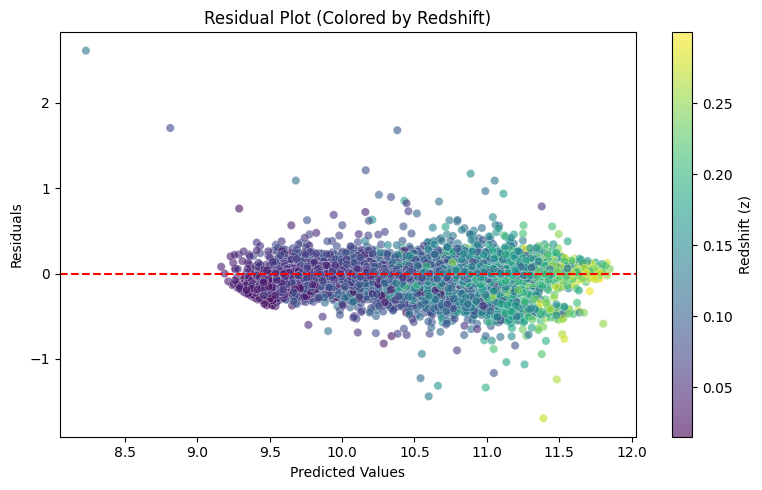

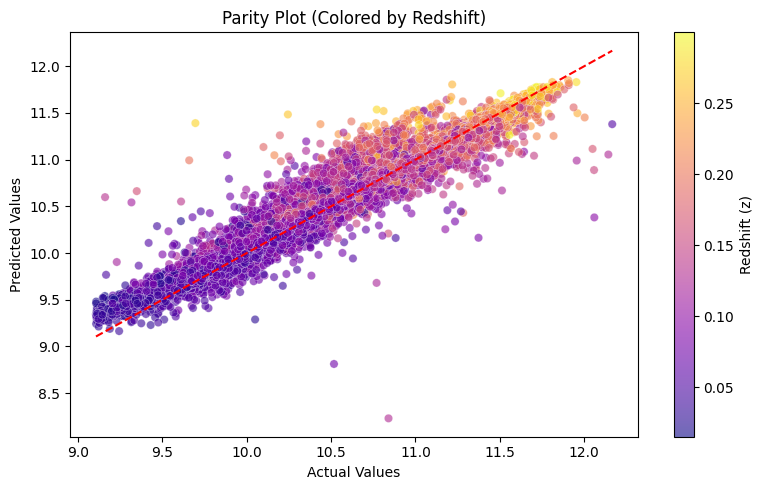

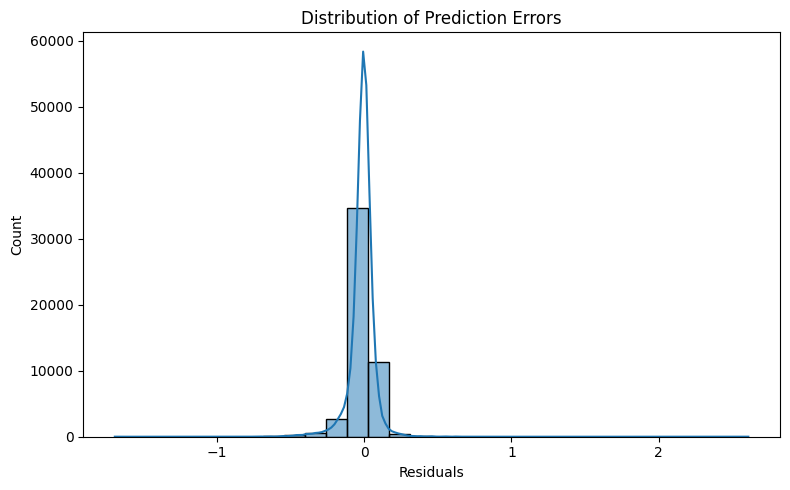

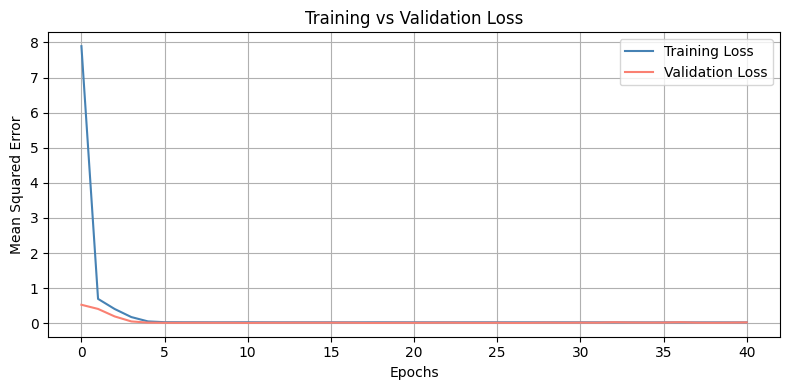

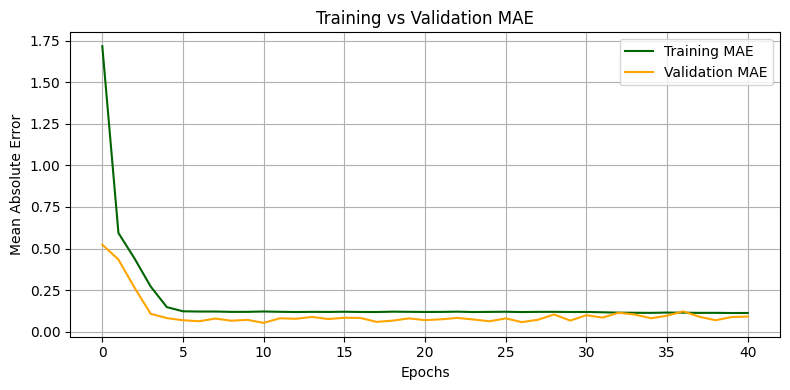

In [64]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)

### Top featrues with Transfer Learning

In [11]:
top_features = ["velocityDisp", "z", "modelMag_z", "modelMag_u", "d4000", "petroRad_r", "modelMag_r", "zErr", "nii_6584_flux", "lick_mgb", "fracDev_r", "oiii_5007_flux"]

In [12]:
df = pd.read_csv('data/processed/spectrometry_photometry.csv')
X = df[top_features].copy()
y = df[target_col].copy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1 (frozen)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)
x = layers.BatchNormalization(name='BatchNorm_64')(x)
x = layers.Activation('relu', name='Activation_64')(x)

# Layer 2 (frozen)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)
x = layers.BatchNormalization(name='BatchNorm_128')(x)
x = layers.Activation('relu', name='Activation_128')(x)

# Layer 3 (trainable)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_new')(x)
x = layers.Dropout(0.2, name='Dropout_128_new')(x)
x = layers.BatchNormalization(name='BatchNorm_128_new')(x)
x = layers.Activation('relu', name='Activation_128_new')(x)

# Layer 4 (trainable)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64_new')(x)
x = layers.Dropout(0.2, name='Dropout_64_new')(x)
x = layers.BatchNormalization(name='BatchNorm_64_new')(x)
x = layers.Activation('relu', name='Activation_64_new')(x)

# Layer 5 (trainable)
x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), name='Dense_32_new')(x)
x = layers.Dropout(0.2, name='Dropout_32_new')(x)
x = layers.BatchNormalization(name='BatchNorm_32_new')(x)
x = layers.Activation('relu', name='Activation_32_new')(x)

# Output
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Top_Features_Transfer_Learned_Regression_Model')

# Load base model weights
model.load_weights('models/spectro_photo_base_regression_model.h5', by_name=True, skip_mismatch=True)

# Freeze reused layers
model.get_layer('Dense_64').trainable = False
model.get_layer('Dense_128').trainable = False

# Compile
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()


Model: "Top_Features_Transfer_Learned_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 12)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                832       
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 BatchNorm_64 (BatchNormaliz  (None, 64)               256       
 ation)                                                          
                                                                 
 Activation_64 (Activation)  (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                    

In [16]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2922/2922 [==============================] - 22s 7ms/step - loss: 5.2586 - mae: 1.3872 - mse: 4.9864 - mape: 13.0317 - val_loss: 1.2857 - val_mae: 0.7220 - val_mse: 1.0368 - val_mape: 6.7990
Epoch 2/200
2922/2922 [==============================] - 20s 7ms/step - loss: 0.7146 - mae: 0.5511 - mse: 0.5077 - mape: 5.2058 - val_loss: 0.6351 - val_mae: 0.5105 - val_mse: 0.4748 - val_mape: 4.7606
Epoch 3/200
2922/2922 [==============================] - 20s 7ms/step - loss: 0.4006 - mae: 0.4027 - mse: 0.2813 - mape: 3.8139 - val_loss: 0.2736 - val_mae: 0.3144 - val_mse: 0.1859 - val_mape: 2.9678
Epoch 4/200
2922/2922 [==============================] - 20s 7ms/step - loss: 0.2179 - mae: 0.2862 - mse: 0.1499 - mape: 2.7176 - val_loss: 0.1254 - val_mae: 0.1768 - val_mse: 0.0753 - val_mape: 1.6937
Epoch 5/200
2922/2922 [==============================] - 20s 7ms/step - loss: 0.1110 - mae: 0.1996 - mse: 0.0721 - mape: 1.8977 - val_loss: 0.0560 - val_mae: 0.1141 - val_mse: 0.0249 - val_ma

In [17]:
y_pred = model.predict(X_test_scaled)

1566/1566 [==============================] - 4s 2ms/step


In [18]:
model.save('models/top_features_transfer_learned_regression_model.h5')

In [19]:
plot_metrics(y_test, y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.1072 dex
Root Mean Squared Error (RMSE): 0.1460 dex
R² Score: 0.9122
Fraction within ±0.20 dex: 86.90%


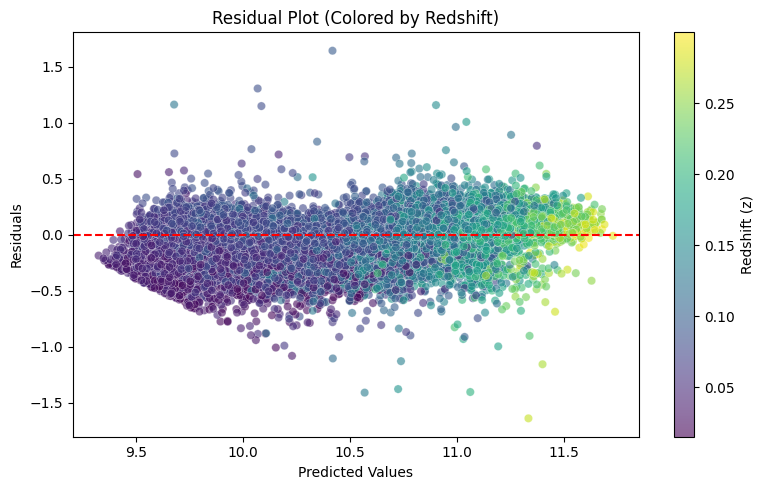

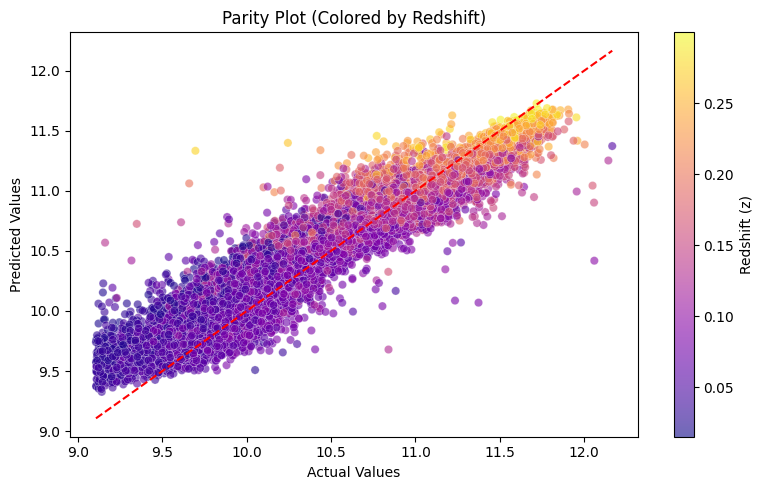

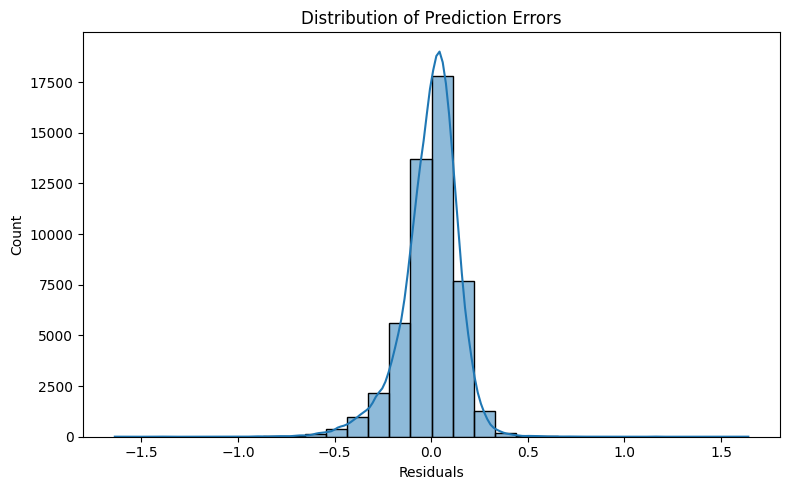

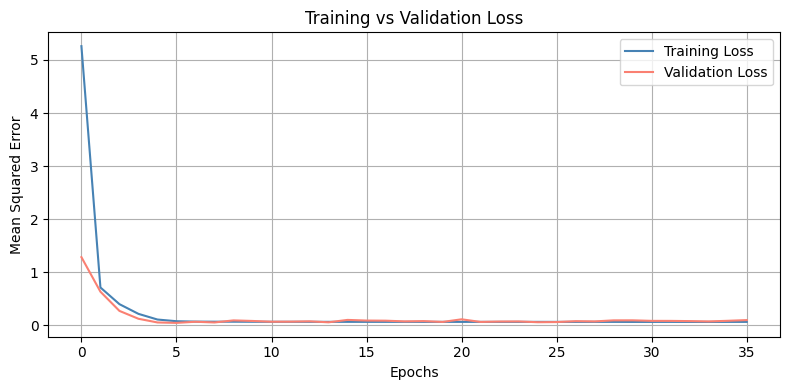

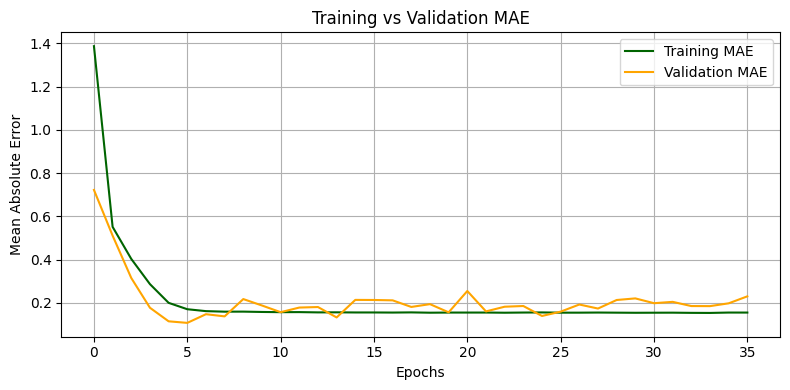

In [20]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)

### Top Features (reducing) Neural Network

In [29]:
top_features = ["velocityDisp", "z", "modelMag_z", "modelMag_u", "d4000", "petroRad_r", "modelMag_r", "zErr", "nii_6584_flux", "lick_mgb", "fracDev_r", "oiii_5007_flux"]

Model: "Top_6_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 6)]               0         
                                                                 
 Dense_128 (Dense)           (None, 128)               896       
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                   

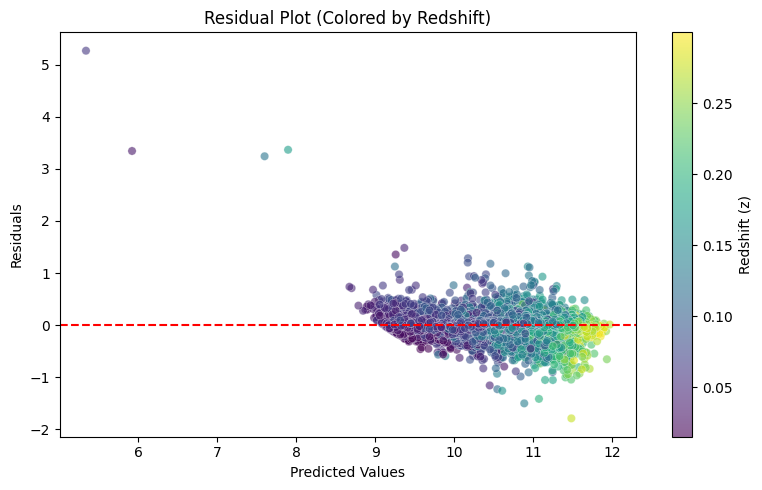

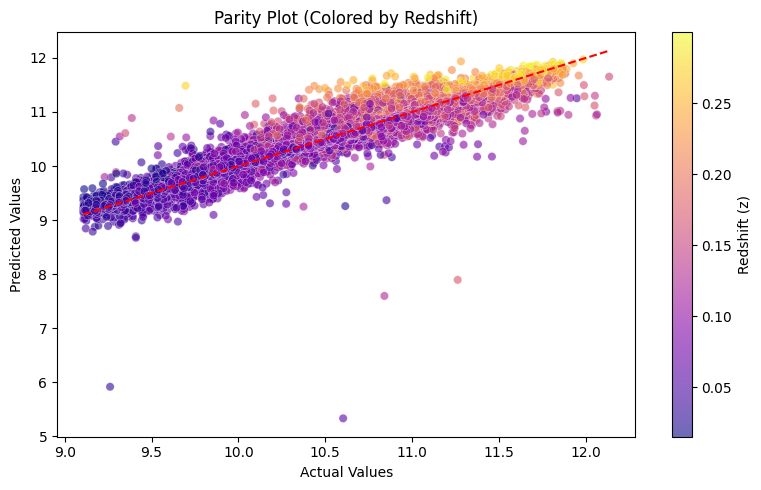

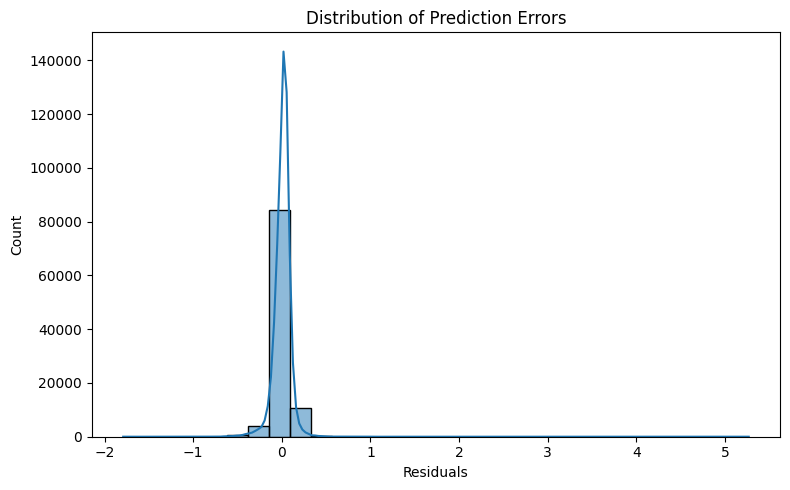

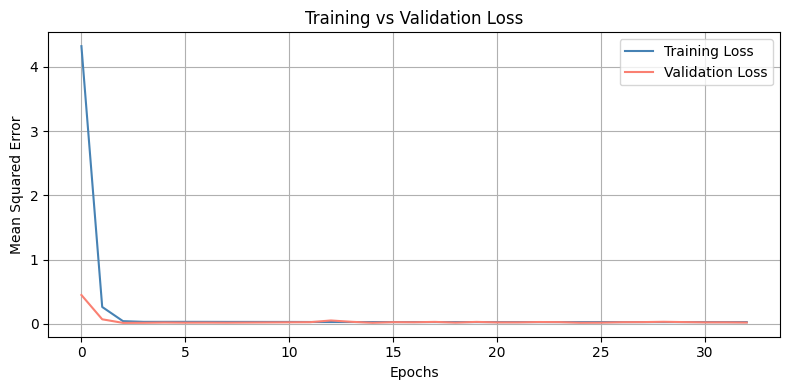

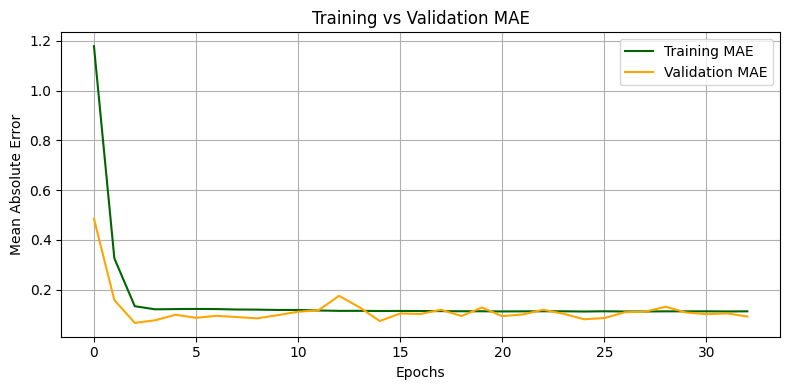

Model: "Top_7_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 7)]               0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1024      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                   

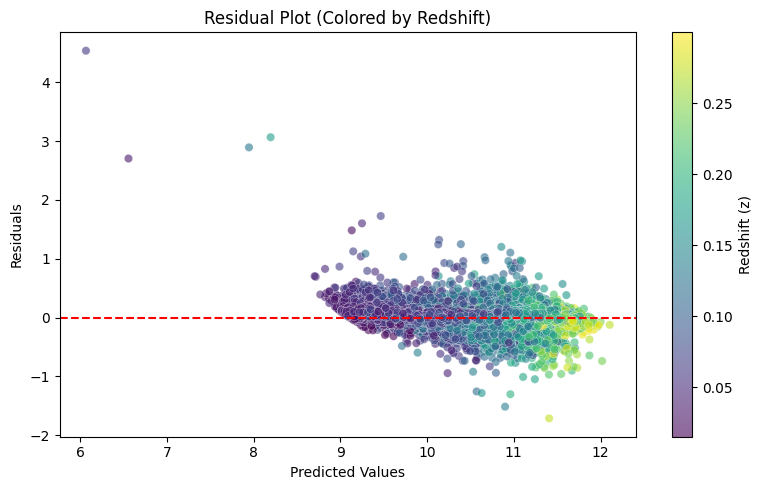

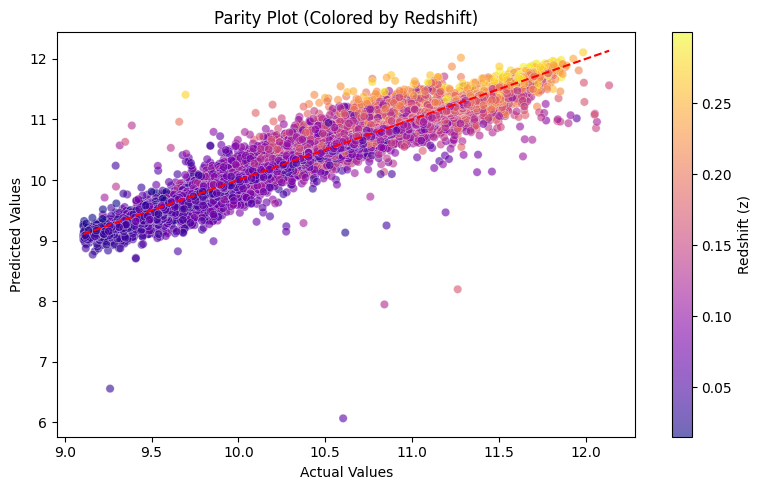

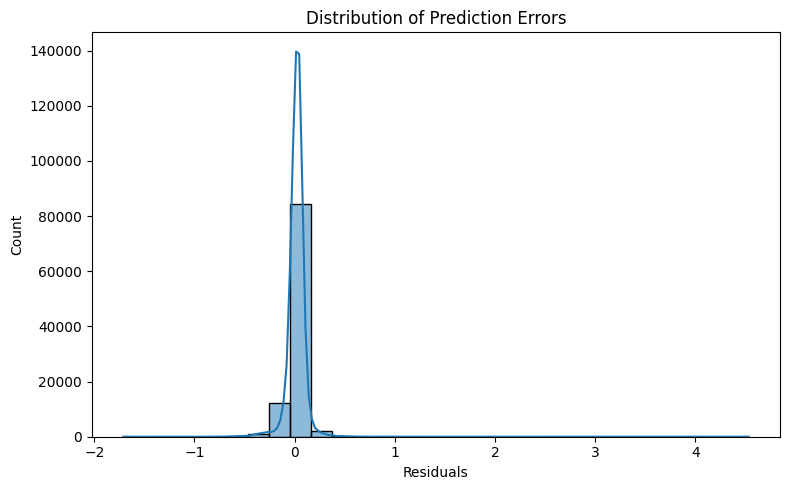

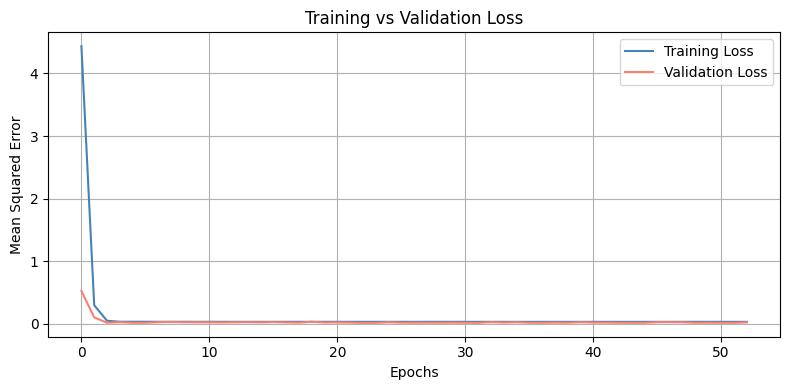

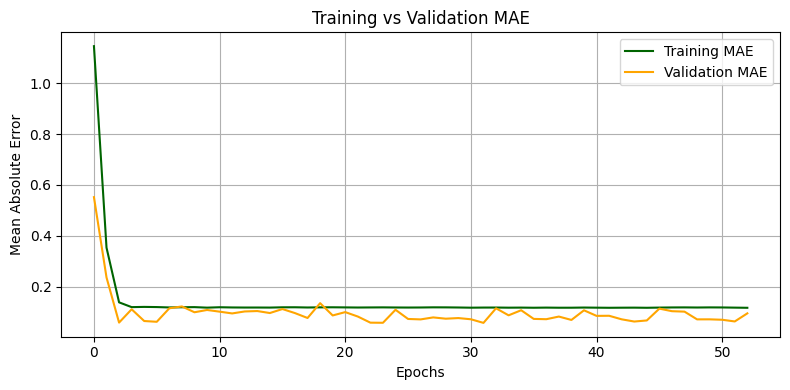

Model: "Top_8_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 8)]               0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1152      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                   

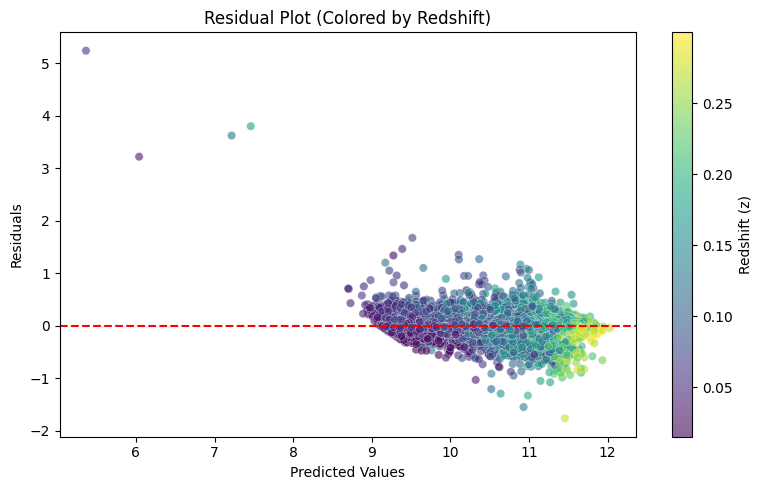

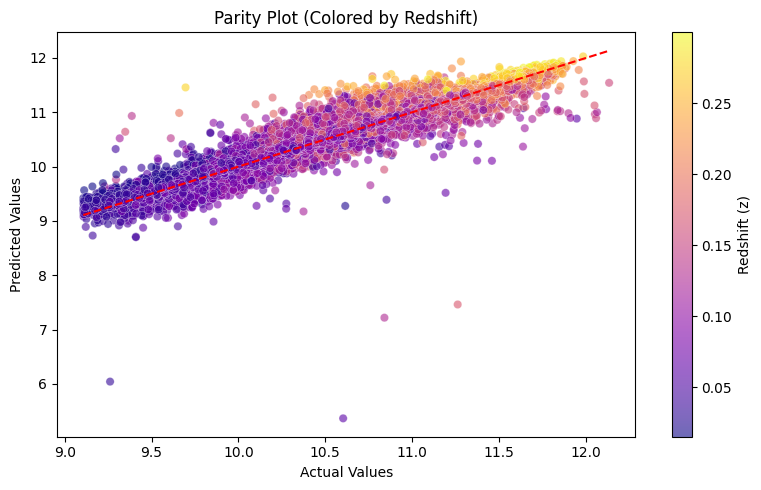

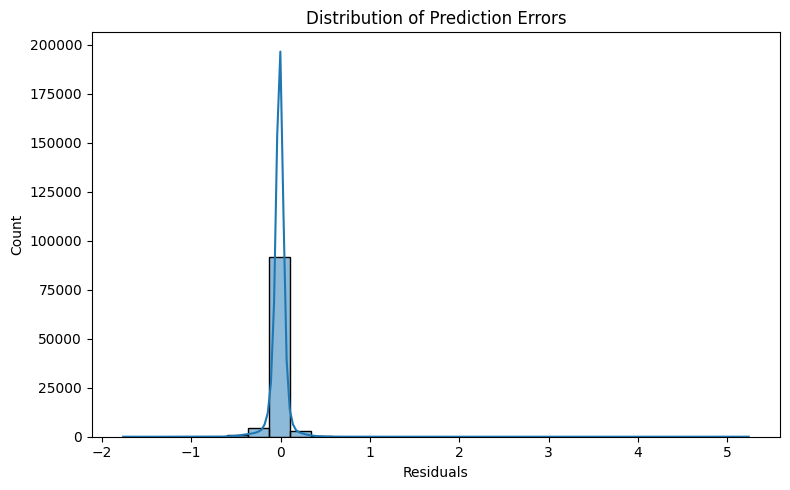

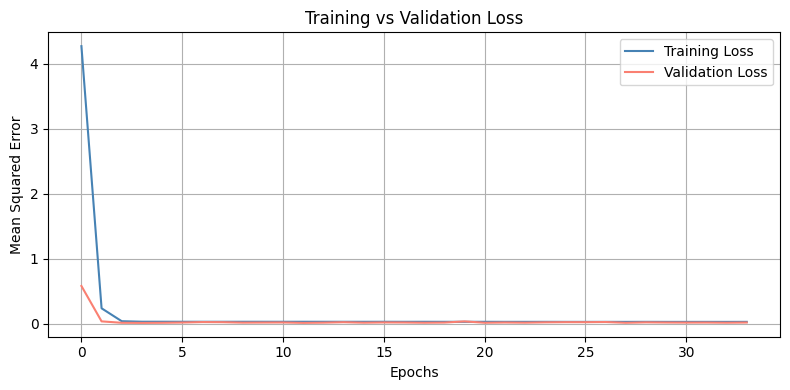

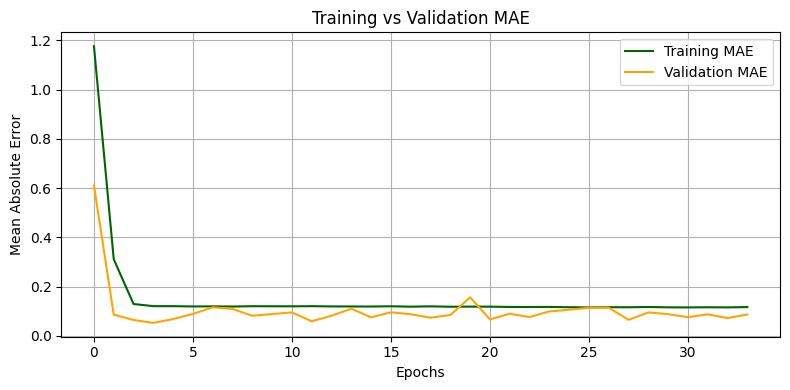

Model: "Top_9_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 9)]               0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1280      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                   

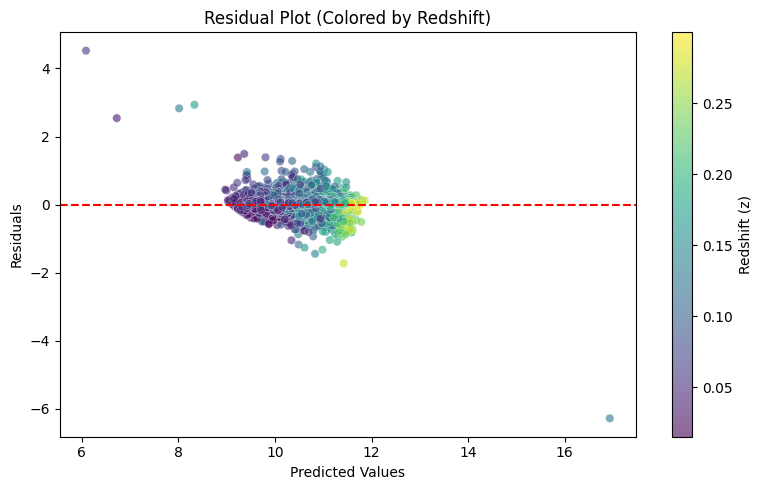

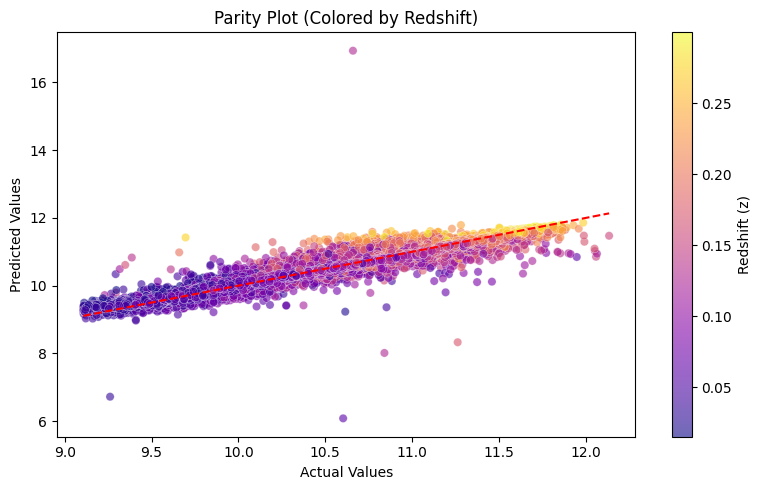

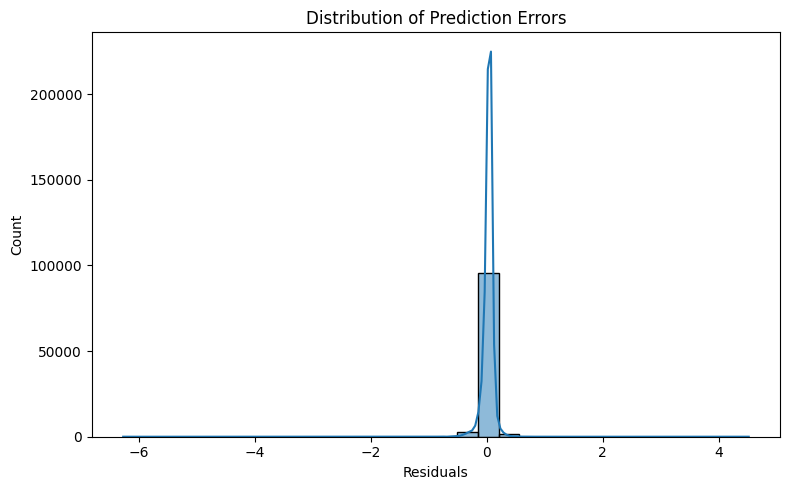

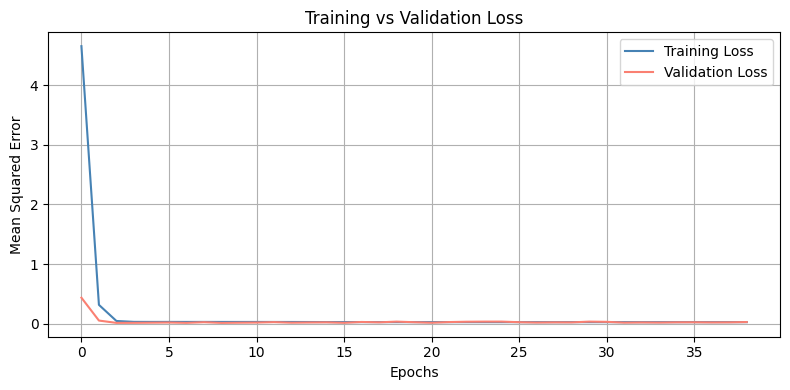

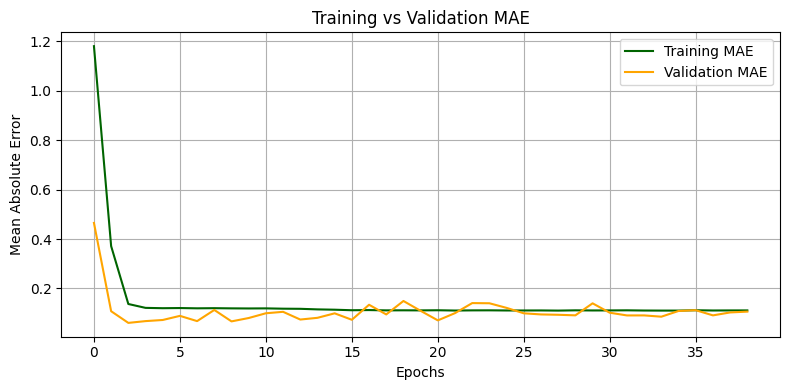

Model: "Top_10_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10)]              0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1408      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                  

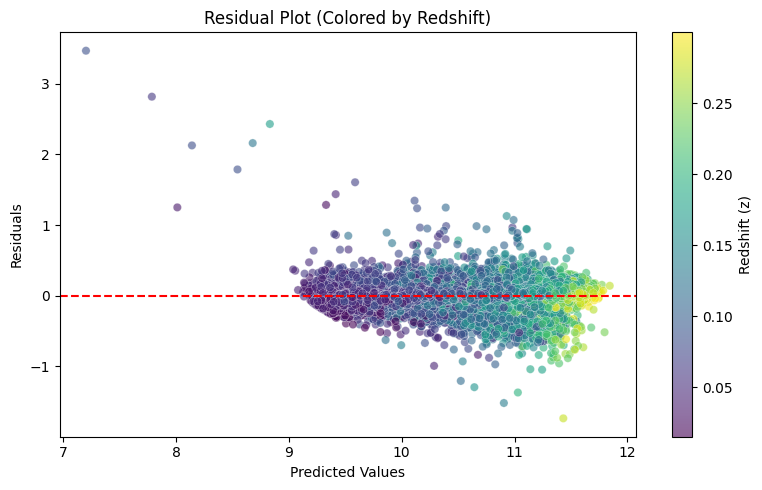

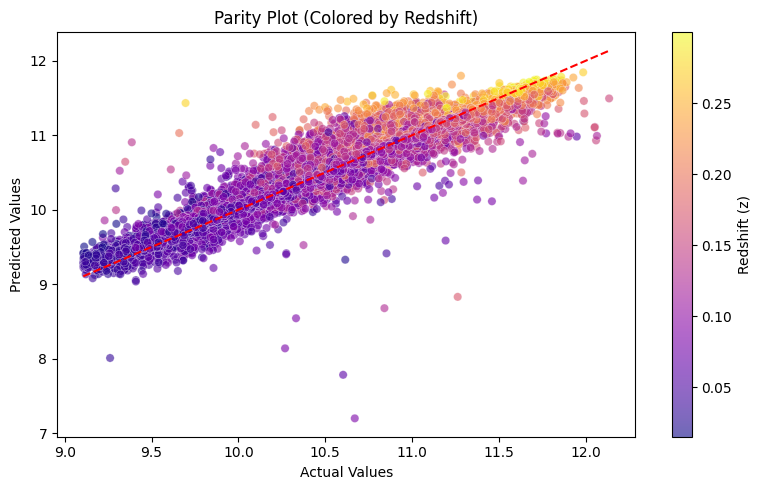

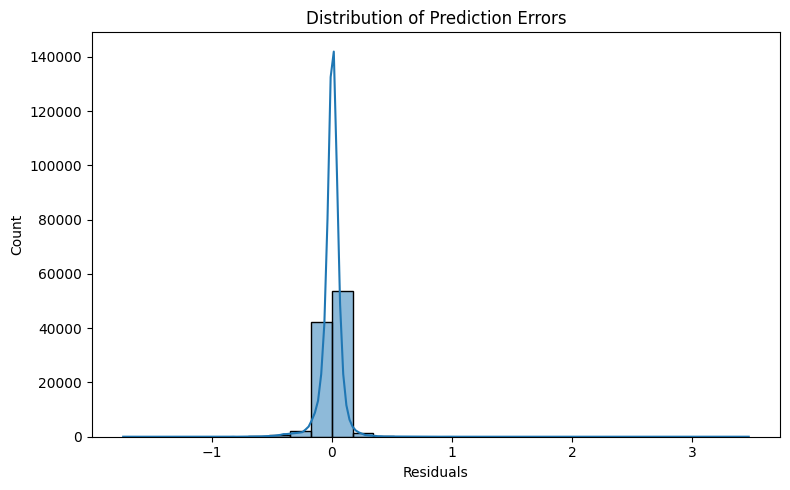

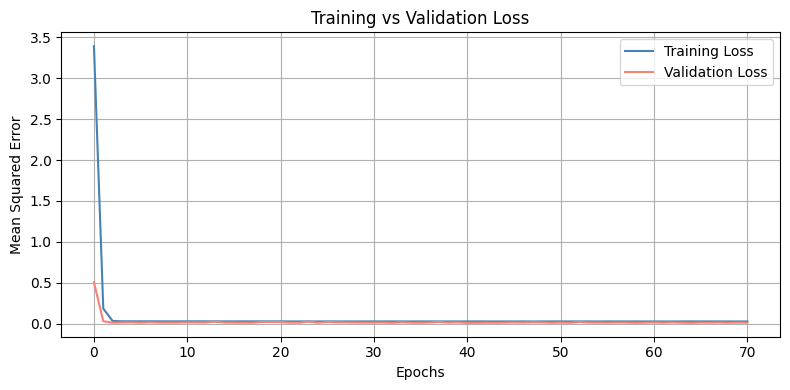

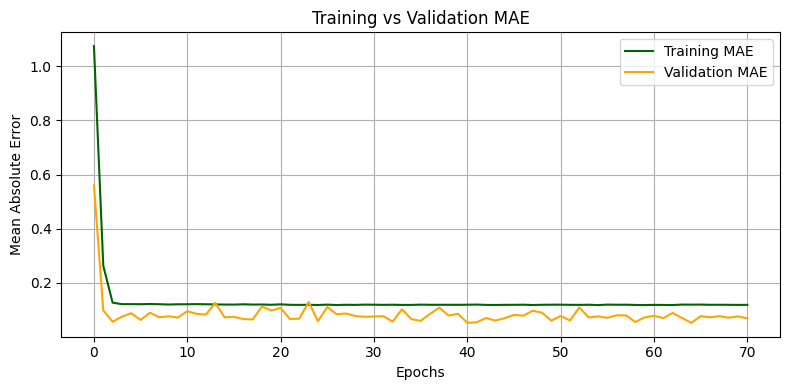

Model: "Top_11_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 11)]              0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1536      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                  

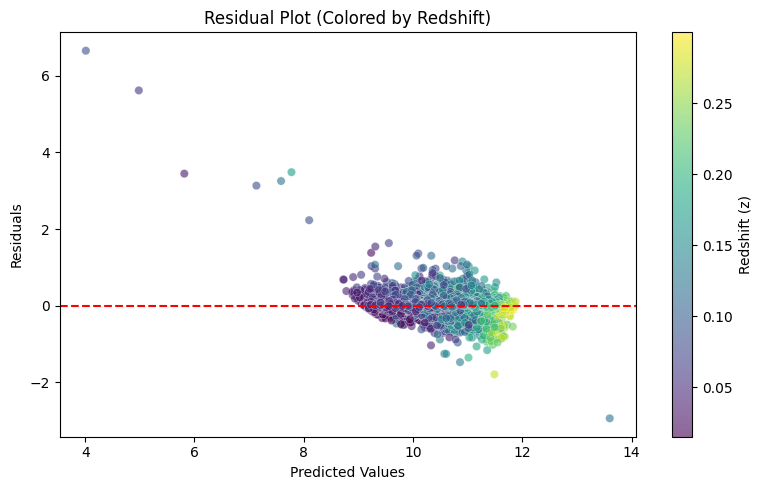

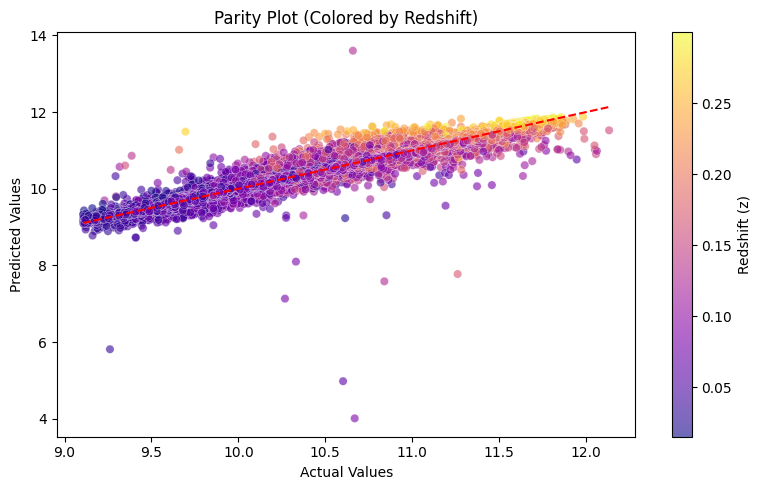

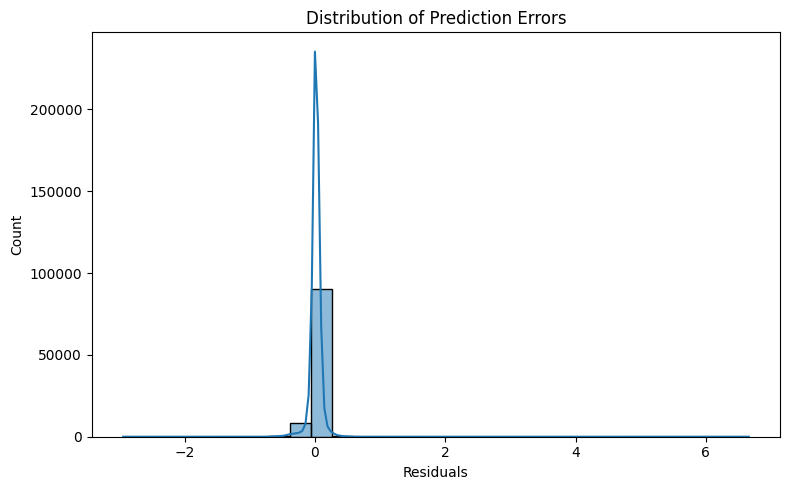

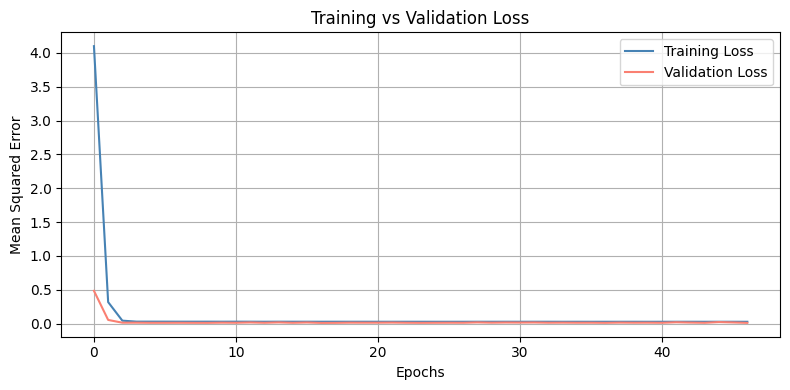

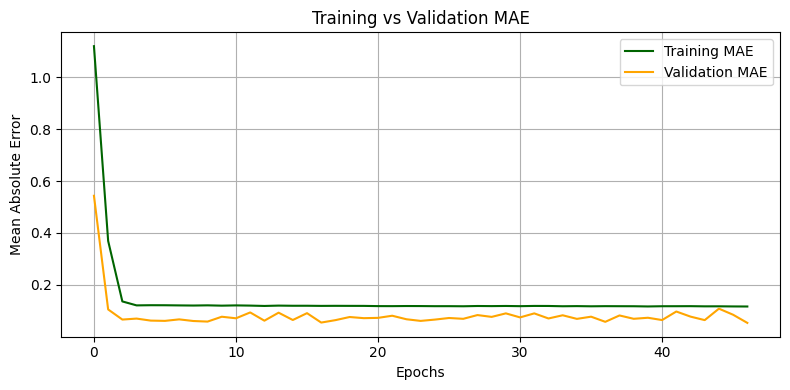

Model: "Top_12_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 12)]              0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1664      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                  

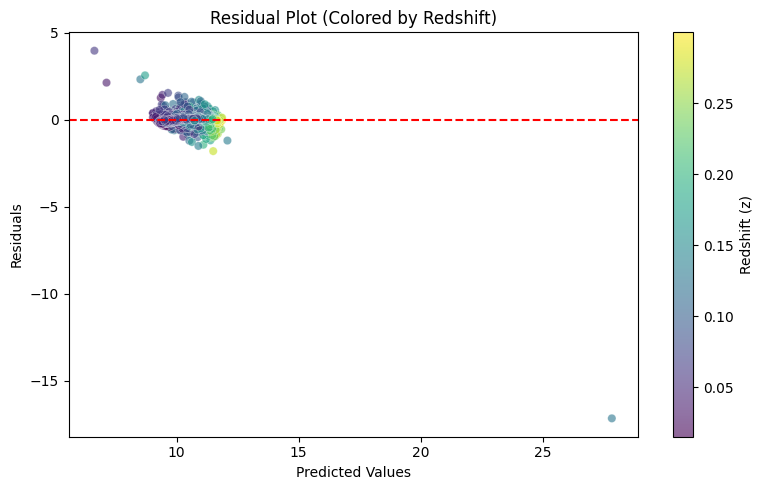

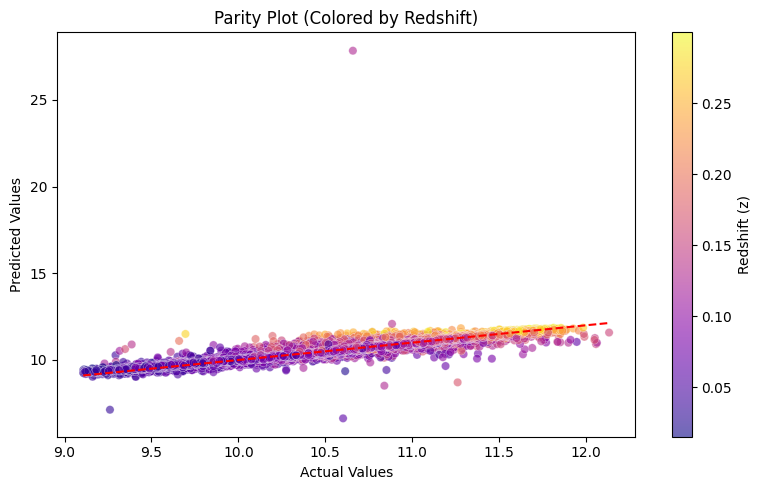

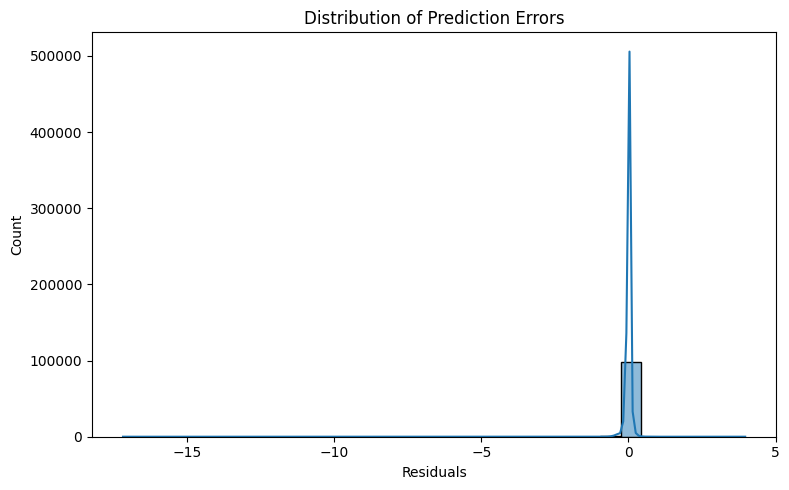

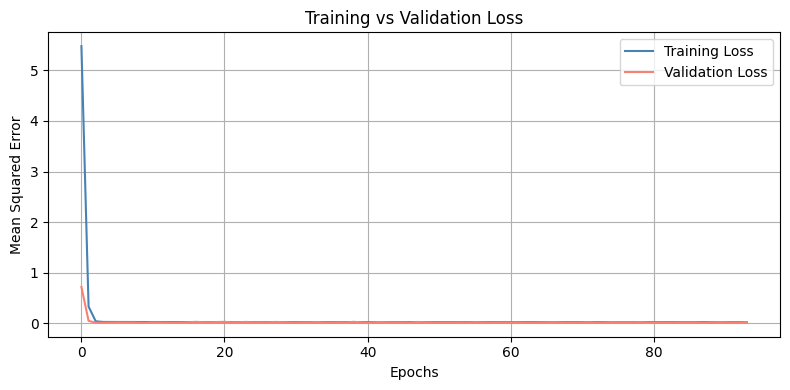

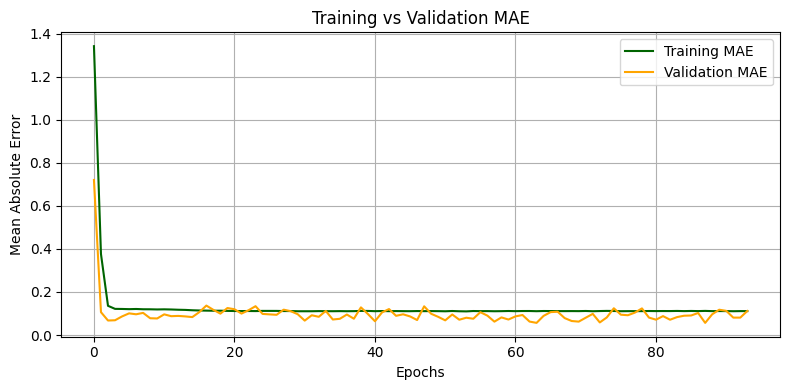

In [31]:
df_specs = pd.read_csv('data/processed/spectrometry_photometry.csv')
df_photo = pd.read_csv('data/processed/photometry_only.csv')

df = pd.concat([df_specs, df_photo], ignore_index=True)

for i in range(6,13, 1):
    X = df[top_features[:i]].copy()
    y = df[target_col].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    input_shape = X_train_scaled.shape[1]

    optimizer = Adam(learning_rate=0.001)

    inputs = keras.Input(shape=(input_shape,), name='Input')

    # Layer 1
    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(inputs)
    x = layers.Dropout(0.2, name='Dropout_128')(x)
    x = layers.BatchNormalization(name='BatchNorm_128')(x)
    x = layers.Activation('relu', name='Activation_128')(x)

    # Layer 2
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(x)
    x = layers.Dropout(0.2, name='Dropout_64')(x)
    x = layers.BatchNormalization(name='BatchNorm_64')(x)
    x = layers.Activation('relu', name='Activation_64')(x)

    # Layer 3
    x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), name='Dense_32')(x)
    x = layers.Dropout(0.2, name='Dropout_32')(x)
    x = layers.BatchNormalization(name='BatchNorm_32')(x)
    x = layers.Activation('relu', name='Activation_32')(x)

    # Output
    outputs = layers.Dense(1, name='Output')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=f'Top_{i}_Features_Regression_Model')

    # Compile
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    model.compile(optimizer=optimizer, 
                loss=tf.keras.losses.mean_squared_error, 
                metrics=['mae', 'mse', 'mape'])

    model.summary()


    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    model.save(f'models/top_{i}_features_regression_model.h5')
    
    y_pred = model.predict(X_test_scaled)
    print(f"Metrics for top {i} features model:")
    plot_metrics(y_test, y_pred)
    print(f"Visualizations for top {i} features model:")
    plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)
